In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import librosa
import librosa.display
import scipy.constants as const
import scipy
import IPython.display
from scipy.io import wavfile
from IPython.core.display import HTML
from __future__ import division
from tensorflow.python.platform import gfile
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from tensorflow.python.tools import freeze_graph
import matplotlib.pyplot as plt

In [3]:
PATH_TEST = "./dataset/test"
PATH_TRAINING = "./dataset/train"
n_mfcc = 20
mfcc_start = 0
mfcc_end = 20
mfcc_stored = mfcc_end - mfcc_start
n_samples = 6

def load_vowel(folder, size=4):
    wav_files = os.listdir(folder)[0:size]
    dataset = np.ndarray(shape=(len(wav_files) * 8, mfcc_stored, n_samples), dtype=np.float32)
    num_files = 0
    for wav_file in wav_files:
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
        
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.125, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
        
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.25, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
        
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.375, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
        
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.5, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
        
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.625, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
        
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.75, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
        
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.875, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 200
        num_files += 1
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


In [4]:
def load_datasets(folder, size):
    vowels = os.listdir(folder)
    label = 0
    vowels_amount = len(vowels)
    datasets = np.ndarray(shape=(vowels_amount * size * 8, mfcc_stored, n_samples), dtype=np.float32)
    labels = np.ndarray(shape=(vowels_amount * size * 8), dtype=np.int)
    ind_start, ind_end = 0, size *8
    for vowel in vowels:
        vowel_folder = os.path.join(folder, vowel)
        vowel_dataset = load_vowel(vowel_folder, size)
        datasets[ind_start:ind_end,:,:] = vowel_dataset
        labels[ind_start:ind_end] = label
        ind_start += size * 8
        ind_end += size * 8
        label += 1
    print("Datasets Shape:", datasets.shape, labels.shape)
    return datasets, labels

datasets, labels = load_datasets(PATH_TRAINING, 4)

#Randomize dataset
np.random.seed(133)
permutation = np.random.permutation(labels.shape[0])
datasets = datasets[permutation,:,:]
labels = labels[permutation]

#save dataset
pickle_file = os.path.join("./", 'vowels.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': datasets,
    'train_labels': labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise



Full dataset tensor: (32, 20, 6)
Mean: 0.002263088
Standard deviation: 0.28876427
Full dataset tensor: (32, 20, 6)
Mean: -8.529096e-05
Standard deviation: 0.3437524
Full dataset tensor: (32, 20, 6)
Mean: 0.002041483
Standard deviation: 0.32866862
Full dataset tensor: (32, 20, 6)
Mean: 0.0044583115
Standard deviation: 0.36659002
Full dataset tensor: (32, 20, 6)
Mean: -0.007859334
Standard deviation: 0.42994225
Full dataset tensor: (32, 20, 6)
Mean: -0.0023001232
Standard deviation: 0.37406784
Full dataset tensor: (32, 20, 6)
Mean: -0.048689034
Standard deviation: 0.4482279
Datasets Shape: (224, 20, 6) (224,)


(25, 13)


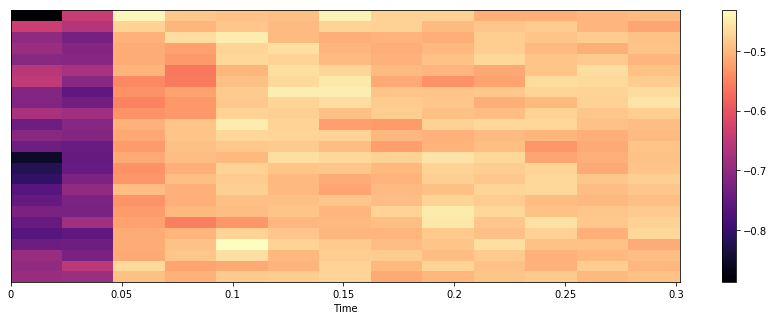

In [81]:
mfccs = datasets[3,:,:]
plt.figure(figsize=(15,5))
plt.title = "MFCC"

other = np.asarray([[-0.6923731, -0.6866575, -0.4907845, -0.5046053, -0.4812429, -0.4783602, -0.4718884, -0.5127567, -0.5003926, -0.4871306, -0.4811026, -0.4982233, -0.4887495],[-0.6994145, -0.6518744, -0.4658121, -0.5165183, -0.5120193, -0.5026882, -0.4732534, -0.4982809, -0.4716989, -0.4883963, -0.5046667, -0.4781285, -0.5003163],[-0.6914756, -0.7256678, -0.5116439, -0.4861388, -0.4600886, -0.4978158, -0.4782666, -0.4792494, -0.4937109, -0.4812925, -0.505043, -0.4981351, -0.4934323],[-0.7423533, -0.737304, -0.5107797, -0.4884748, -0.4310695, -0.4727522, -0.481948, -0.4942882, -0.4874448, -0.4602431, -0.4896494, -0.4883934, -0.5096158],[-0.7648003, -0.7538806, -0.5094384, -0.5009922, -0.4728285, -0.4854127, -0.5013264, -0.5021604, -0.4818664, -0.4910938, -0.474319, -0.5065753, -0.4684232],[-0.7461025, -0.6835181, -0.5200111, -0.5531805, -0.5319076, -0.499757, -0.4973618, -0.4919881, -0.4537838, -0.4859326, -0.4584763, -0.4844208, -0.474289],[-0.7257581, -0.7274759, -0.5254108, -0.4982501, -0.4937756, -0.4877979, -0.5005925, -0.4734873, -0.4503406, -0.4685181, -0.4886954, -0.4860454, -0.4822057],[-0.7510502, -0.7218316, -0.5327671, -0.5062499, -0.4898093, -0.4899499, -0.4856581, -0.4943372, -0.4705821, -0.4798272, -0.4950685, -0.4985943, -0.4918835],[-0.7634727, -0.6993608, -0.4950949, -0.5061769, -0.4762523, -0.4978312, -0.5165401, -0.4954418, -0.4912461, -0.4717831, -0.4677967, -0.4944181, -0.4847778],[-0.8060896, -0.7215099, -0.5314006, -0.4920982, -0.4798537, -0.4978192, -0.51065, -0.503841, -0.4772306, -0.4837584, -0.4674732, -0.4851959, -0.4772013],[-0.81774, -0.7465999, -0.5344263, -0.5075384, -0.4722191, -0.4870673, -0.48579, -0.4972979, -0.4729694, -0.478571, -0.4707265, -0.5124249, -0.4864654],[-0.8513062, -0.748189, -0.5128039, -0.4935275, -0.4985091, -0.4599278, -0.4676934, -0.474686, -0.4573267, -0.4694424, -0.5178152, -0.5074592, -0.4882946],[-0.7383927, -0.7460294, -0.5256585, -0.4914636, -0.4830643, -0.4814394, -0.4943508, -0.5229667, -0.5026032, -0.4918527, -0.5311405, -0.5122969, -0.4878923],[-0.708307, -0.7133347, -0.5143939, -0.4865655, -0.4689324, -0.470508, -0.4737079, -0.4990944, -0.5050047, -0.4953766, -0.500663, -0.5087962, -0.4957435],[-0.7373954, -0.7122675, -0.5055062, -0.4867535, -0.4487781, -0.4724162, -0.5226895, -0.5259567, -0.4748634, -0.4667473, -0.4698825, -0.4888203, -0.4943985],[-0.673797, -0.6833159, -0.5327029, -0.5291833, -0.472032, -0.4769642, -0.4908413, -0.479032, -0.4911154, -0.4936467, -0.4733739, -0.4853368, -0.4786851],[-0.7177875, -0.7367923, -0.5494475, -0.5302311, -0.4833711, -0.4702683, -0.4617831, -0.4802825, -0.4846612, -0.5078804, -0.4980639, -0.4745752, -0.4561058],[-0.7150345, -0.7560655, -0.5351474, -0.5193802, -0.4820318, -0.4456904, -0.4463005, -0.4872293, -0.4873827, -0.4835555, -0.4712298, -0.4735577, -0.4648583],[-0.6486339, -0.7071985, -0.5447673, -0.5568536, -0.4899283, -0.4659044, -0.4520869, -0.5113267, -0.5348949, -0.5185094, -0.4646845, -0.4654994, -0.4805563],[-0.6584264, -0.6744861, -0.5030528, -0.5607377, -0.5006081, -0.4607392, -0.4711732, -0.496645, -0.5017421, -0.5134077, -0.4870441, -0.4615899, -0.4885234],[-0.707935, -0.7120649, -0.5104138, -0.5282019, -0.4689358, -0.4722854, -0.4964333, -0.5041111, -0.4882536, -0.4700487, -0.4867193, -0.4809232, -0.5004817],[-0.6893249, -0.7140459, -0.509423, -0.5217986, -0.4710496, -0.4610164, -0.5020482, -0.5087641, -0.4972803, -0.4778817, -0.4967815, -0.5092717, -0.4874543],[-0.7002973, -0.7292436, -0.5044175, -0.4626875, -0.4484254, -0.4956028, -0.5081065, -0.5037709, -0.5089232, -0.4786159, -0.4867086, -0.4807151, -0.4887258],[-0.6362632, -0.6614246, -0.4728621, -0.50096, -0.4860313, -0.4956293, -0.4733192, -0.4746677, -0.4963431, -0.4859842, -0.4801064, -0.5019186, -0.5172328],[-0.8866938, -0.6395247, -0.4385285, -0.4839411, -0.4892424, -0.492136, -0.4431229, -0.4742717, -0.4752559, -0.5082528, -0.505951, -0.5016147, -0.4968558]], dtype=np.float32)

print(other.shape)

librosa.display.specshow(other, x_axis='time')
plt.colorbar()

In [6]:
num_labels = 7

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, mfcc_stored * n_samples)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(datasets, labels)
print('Training set', train_dataset.shape, train_labels.shape)

Training set (224, 120) (224, 7)


In [7]:

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(num_labels * 4 * 8, mfcc_stored * n_samples))
    tf_train_labels = tf.placeholder(tf.float32, shape=(num_labels * 4 * 8, num_labels))

    weights = tf.Variable(tf.truncated_normal([mfcc_stored * n_samples, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))

    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    
    tf_inference_input = tf.placeholder(tf.float32,shape=(1, mfcc_stored * n_samples), name="input")
    inf_logits = tf.matmul(tf_inference_input, weights) + biases
    inf_prediction = tf.nn.softmax(inf_logits, name="prediction")

In [8]:
num_steps = 2001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    feed_dict = {tf_train_dataset : train_dataset, tf_train_labels : train_labels}
    for step in range(num_steps):
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels))
    saver = tf.train.Saver()
    last_checkpoint = './model.cptk'
    saver.save(session, last_checkpoint)
    tf.train.write_graph(session.graph_def, "./", 'raw_graph_def.pb', as_text=False)
    print("Saved checkpoint")

Initialized
Loss at step 0: 4.012242
Training accuracy: 12.9%
Loss at step 100: 1.545997
Training accuracy: 44.2%
Loss at step 200: 1.180751
Training accuracy: 59.4%
Loss at step 300: 0.951469
Training accuracy: 82.6%
Loss at step 400: 0.788251
Training accuracy: 92.0%
Loss at step 500: 0.667219
Training accuracy: 94.2%
Loss at step 600: 0.575230
Training accuracy: 96.0%
Loss at step 700: 0.503749
Training accuracy: 96.4%
Loss at step 800: 0.447050
Training accuracy: 96.4%
Loss at step 900: 0.401226
Training accuracy: 96.9%
Loss at step 1000: 0.363567
Training accuracy: 96.9%
Loss at step 1100: 0.332155
Training accuracy: 97.8%
Loss at step 1200: 0.305607
Training accuracy: 98.7%
Loss at step 1300: 0.282907
Training accuracy: 99.1%
Loss at step 1400: 0.263296
Training accuracy: 99.1%
Loss at step 1500: 0.246198
Training accuracy: 99.1%
Loss at step 1600: 0.231166
Training accuracy: 99.1%
Loss at step 1700: 0.217854
Training accuracy: 99.1%
Loss at step 1800: 0.205986
Training accuracy:

In [9]:

freeze_graph.freeze_graph(input_graph = './raw_graph_def.pb',
              input_binary = True,
              input_checkpoint = last_checkpoint,
              output_node_names = "prediction",
              output_graph = './model.bytes' ,
              clear_devices = True, initializer_nodes = "",input_saver = "",
              restore_op_name = "save/restore_all", filename_tensor_name = "save/Const:0")

INFO:tensorflow:Restoring parameters from ./model.cptk
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
